# Overview

## Context 

This notebook forms part of a series on computational optical radiometry.  The notebooks can be downloaded from \cite{Willers2014github}. These notebooks are constantly revised and updated, please revisit from time to time.  


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Objective

This notebook provides a phased example of flux transfer between a source area and a receiving area, through an attenuating path with path radiance.  The calculations are  performed in different spectral formats, starting from first principle Planck law theory.  Pre-computed atmospheric transmittance and path radiance tables are provided.

The problem is defined and demonstrated in three phases, each building on the previous:

1. Study the provided atmospheric data: spectral attenuation and path radiance.
1. A sensor observes a thermal radiator source with unity emissivity though the atmosphere.
1. Tilt the source, use a non-unity eissivity, and add reflected sunlight to the self emission.
1. Using a spectrally varying source emissivity on the tilted source reflecting sunlight.

At the conclusion of this example the reader should be acquainted with thermal radiation, reflected sunlight and the effect of atmospheric attenuation and path radiance in wavenumber and wavelength spectral domains.

This notebook and the data used in the calculation is available at  \cite{Willers2014github}. 

Please read \textit{all} of the following before embarking on the work.


## Spectral variables 

The topic of spectral variables is discussed in great length in the notebook\\\\\
\lstinline{04-IntroductionToComputationalRadiometryWithPyradi.ipynb}\\\\
Details are not repeated here, please review the above notebook.



# Scenario

A MWIR (3--5~\mu$m) sensor is viewing a thermal radiating  target and the background (no target in field of view) along horizontal paths at a number of different distances.

A radiating source (the target), and receiving area (the sensor), are located on a horizontal plane, separated by a distance $R$. The target is viewed against a background at a distance of 75~\si{\kilo\metre}.
The path between the target and sensor has atmospheric attenuation and path radiance, as defined above.

The sensor has a shield to define a conical solid angle for receiving flux. Any source outside this solid angle has no effect on the sensor flux.  Only background and the target is visible in the solid angle.

The background in this case is sky radiance of the horizontal path to space (practically, a 75~\si{\kilo\metre} distance is sufficient).  The flux from the background emanates only from the atmospheric sky radiance (not the terrain or some other object).

The target has a square shape with total area of 2~\si{\metre\squared}, a temperature of 40~\si{\celsius} and an emissivity of 1.

The flux transfer takes place in the MWIR spectral band with the response shown in the data file 
`./data/12k/sensor/MWIR.spc`.  This file shows the normalised sensor response (i.e., transmittance) ${S}$ as a function of wavelength in \si{\micro\metre} and wavenumber \si{\centi\metre^{-1}}.  




# Assigment  1: the Atmosphere

## Atmosphere Definition

The atmospheric spectral attenuation $\tau_\textrm{atmT}$ and path radiance $L_\textrm{pathT}$, in the spectral band 1667 to 3333~\si{\centi\metre^{-1}},  were calculated using Modtran for the Midlatitude Summer climatic model and the Navy Maritime aerosol model with 2~\si{\metre\per\second} current wind speed and 4.1~\si{\metre\per\second} 24-hour wind speed.
The Modtran runs were made for distances from 2 to 8~\si{\kilo\metre}, at altitudes $H$ above sea level from 1 to 10~\si{\kilo\metre}.  The Modtran `tape7`-format data files are located in 
`./data/12k/atmoTarget` and `./data/12k/atmoBackground`.\\\\
The filenames contain the distances and heights for the paths in the form \\\\
    `H_{height}_R_{distance}.dat` \\
where all values are in \si{\kilo\metre}.

The Midlatitude Summer vertical profiles are shown below. Note how the temperature and pressure decreases with altitude.

| Altitude km | Pressure mb | Temp K | RelHum | Water g/m3   |
|----------|----------|-------|--------|----------|
| 0        | 1013     | 294.2 | 76.11  | 1.40E+01 |
| 1        | 902      | 289.7 | 65.97  | 9.29E+00 |
| 2        | 802      | 285.2 | 55.15  | 5.89E+00 |
| 3        | 710      | 279.2 | 45.26  | 3.29E+00 |
| 4        | 628      | 273.2 | 39.02  | 1.90E+00 |
| 5        | 554      | 267.2 | 31.39  | 9.99E-01 |
| 6        | 487      | 261.2 | 29.96  | 6.10E-01 |
| 7        | 426      | 254.7 | 30.29  | 3.69E-01 |
| 8        | 372      | 248.2 | 29.61  | 2.10E-01 |
| 9        | 324      | 241.7 | 30.13  | 1.20E-01 |
| 10       | 281      | 235.3 | 29.42  | 6.39E-02 |


## Tape7 Units

The `tape7` format, and tools to read the files are given in `08-ModtranFileProcessing.ipynb`.  Please consult the notebook for more details.  Here is a summary of the units used  in  `tape7` files.
The format differs depending on the type of Modtran run.

Modtran does calculations in the wavenumber domain with units \si{\centi\metre^{-1}}. 
In most (all?) `tape7` files the wavenumber is the first column in the file.  The column header is `FREQ`.

Depending on the specific `tape5` setup parameters, the transmittance and optical depth may be in different columns, often with different headers.  Column headers can be `TOT TRANS` or `COMBIN_TRANS`. The file formats are described below.

Path radiance is only present in some Modtran configuration formats.  Units are \si{\watt\per(\centi\metre\squared.\steradian.\centi\metre^{-1})}.
The first part of the denominator represents areal density in \si{\centi\metre\squared}, hence the density must be converted to \si{\metre\squared}.
The second part of the denominator represents solid angle and no further conversion is necessary.
The third part of the denominator represents the spectral density \si{\per\centi\metre^{-1}} and this can be used as-is or it can be converted to a spectral density in the wavelength domain with units \si{\watt\per(\centi\metre\squared.\steradian.\micro\metre)}.


Recall the relationship between wavelength, $\lambda$, and wavenumber, $\tilde{\nu}$:
$\lambda=10^4/\tilde{\nu}$,  and for spectral density 
$dL_\lambda
=-dL_{\tilde{\nu}} 10^4/\lambda^2
=-dL_{\tilde{\nu}} {\tilde{\nu}}^2/10^4
$.
Note the minus sign arising from the derivative: this becomes relevant if wavelength intervals are calculated from wavenumber intervals (or vice versa), then the inverse intervals become negative.  When using `np.trapz()` and you obtain negative integrals, keep this in mind.
This topic is also explored in the 04 notebook  \cite{Willers2016githubCompRadioNotebooks04}.



## Problem Statement 1

Investigate the effect of range (distance) and altitude above sea level on atmospheric transmittance and path radiance.  Plot the atmospheric data, look at the graphs and write up your insights and conclusions for each of the following:
\begin{enumerate}

\item Draw a picture of the atmospheric paths, showing the  atmospheric density  decreasing with altitude.

\item Plot the spectral transmittance against wavelength for a distance of 2~\si{\kilo\metre} for all the given altitudes.

\item Plot the spectral transmittance against wavenumber for a distance of 2~\si{\kilo\metre} for all the given altitudes.

\item Plot the transmittance for an altitude of 1~\si{\kilo\metre} for  all the target distances, as well the distance to the background (75~\si{\kilo\metre}).

\item Plot the path radiance in units of \si{\watt\per(\metre\squared.\steradian.\centi\metre^{-1})} for an altitude of 1~\si{\kilo\metre} for  all the target distances, as well the distance to the background (75~\si{\kilo\metre}).

\item Plot the path radiance in units of \si{\watt\per(\metre\squared.\steradian.\micro\metre)} for an altitude of 1~\si{\kilo\metre} for all the target distances, as well the distance to the background (75~\si{\kilo\metre}).

\item Plot the path radiance in units of \si{\watt\per(\metre\squared.\steradian.\micro\metre)} for all the altitudes and the distance to the background (75~\si{\kilo\metre}).

\item Review all of the above graphs, analyse and compile a list of observations and conclusions.

\end{enumerate}

Review the results in all the above plots and note your observations and conclusions.


In [1]:
# to prepare the Python environment

import numpy as np
import pandas as pd
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.ryplot as ryplot
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils
import re
from scipy.interpolate import interp1d

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

## Solution 1

### Atmospheric profiles 

![](pic/12Kpictures01.png)


The atmosphere provides a thin blanket around the earth, but the aerosol concentration, density and temperature decrease towards higher altitudes. At higher altitudes the atmosphere has a decreasing effect on optical systems. Hence, for a slant path to space, the path section closest to the earth surface dominates the atmospheric effects on electro-optical sensors.
For the horizontal path shown here, this effect is even stronger than for a vertical path. The horizontal path locus  from the sensor to the target follows a longer distance closer to the earth where the density is higher.  As the distance extends away, the further parts of the path has less and less effect.  For all practical purposes the 75~\si{\kilo\metre} horizontal path has the same effect as a path extending all the way to space.


### Loading the data

In [2]:
# to read the atmo tape7 files.
# get a list of all the .dat files in the 12k folder
fns = ryfiles.listFiles('data/12k','*.dat')

wn = None
wl = None
dfAtmo = pd.DataFrame()
for fn in fns:
    # extract distance and altitude from the filename
    grps = re.search('H\_([0-9]+)\_R\_([0-9]+).*', fn, re.IGNORECASE)
    if grps:
        # load the fie tape7 file using pyradi function
        tape7 = rymodtran.loadtape7(fn, ['FREQ', 'TOT_TRANS', 'TOTAL_RAD'] )
        
        # make temporary data frame for data in this file
        df = pd.DataFrame(tape7, columns=['wn','TauA','Lpathcm-1'])
        # create new columns with information extracted from the file name
        df['Path'] = 'Background' if 'Back' in fn else 'Target'
        df['R'] = grps.group(2)
        df['H'] = grps.group(1)
        df['R'] = df['R'].astype(float)
        df['H'] = df['H'].astype(float)
        
        # make copies of wn and wl for future use
        if wn is None:
            wn = df['wn'] 
        if wl is None:
            wl = 1e4 / wn 

        # append to the long dataframe
        dfAtmo = dfAtmo.append(df)

# create wavelenth scale from wavenumber
dfAtmo['wl'] = 1e4 / dfAtmo['wn']
# create um spectral density from cm-1 density, also cm2 to m2
dfAtmo['Lpathum'] = 1e2**2 * dfAtmo['Lpathcm-1'] * (dfAtmo['wn'])**2 / 1e4

# make lists of altitudes and ranges
targAlts = sorted(dfAtmo[dfAtmo['Path']=='Target']['H'].unique())
backAlts = sorted(dfAtmo[dfAtmo['Path']=='Background']['H'].unique())
targDists = sorted(dfAtmo[dfAtmo['Path']=='Target']['R'].unique())
backDists = sorted(dfAtmo[dfAtmo['Path']=='Background']['R'].unique())

print(f'Target altitudes: {targAlts}')
print(f'Target distances: {targDists}')
print(f'Background altitudes: {backAlts}')
print(f'Background distances: {backDists}')

print(f'dfAtmo shape: {dfAtmo.shape}')
print(dfAtmo.head())


Target altitudes: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Target distances: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
Background altitudes: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Background distances: [75.0]
dfAtmo shape: (133280, 8)
       wn          TauA     Lpathcm-1        Path     R     H        wl  \
0  1667.0  1.998600e-05  2.064700e-07  Background  75.0  10.0  5.998800   
1  1668.0  7.101800e-10  2.055900e-07  Background  75.0  10.0  5.995204   
2  1669.0  0.000000e+00  2.047000e-07  Background  75.0  10.0  5.991612   
3  1670.0  2.795300e-15  2.038200e-07  Background  75.0  10.0  5.988024   
4  1671.0  7.040900e-14  2.029400e-07  Background  75.0  10.0  5.984440   

    Lpathum  
0  0.573757  
1  0.571997  
2  0.570204  
3  0.568434  
4  0.566657  


After reading in the data, the data frame in memory has all the data for all the cases.  The data frame shape shows the number of rows and columns in the data frame.  The code `dfAtmo.head()`  shows first few lines of the data frame, with all the  columns present.

To extract the relevant information filter from the data frame for altitude `targAlt` and distance `dist`:  

    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist) ]

Next follows the atmospheric transmittance and path radiance plots. 
The spectral absorption by molecules in the atmosphere results in a highly spectrally varying transmittance.  Two graphs are shown below: the raw data as calculated in Modtran and a smoothed  result that better shows the general trend. The smoothing is done using a Savitsky-Golay \cite{Savitzky1964,Press2007,WikipediaSavitzky2021} filter, as implemented in pyradi \cite{pyradiPythontoolkit2012}.

Plot the transmittance for a fixed path length for all target altitudes.

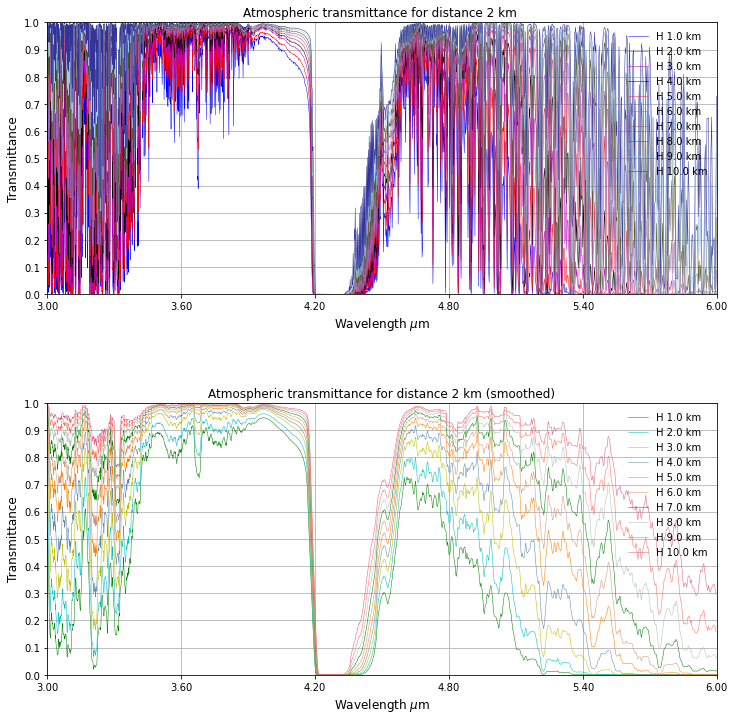

In [3]:
# to plot transmittance vs wavelength for 2 km at different altitudes.
p = ryplot.Plotter(1,2,1,figsize=(12,12))

for targAlt in targAlts:
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    
    p.plot(1,df['wl'],df['TauA'],f'Atmospheric transmittance for distance {dist} km ','Wavelength $\mu$m',
           'Transmittance',label=[f'H {targAlt} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1],linewidths=[0.5])
    p.plot(2,df['wl'],taufilt,f'Atmospheric transmittance for distance {dist} km (smoothed)','Wavelength $\mu$m',
           'Transmittance',label=[f'H {targAlt} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1],linewidths=[0.5])


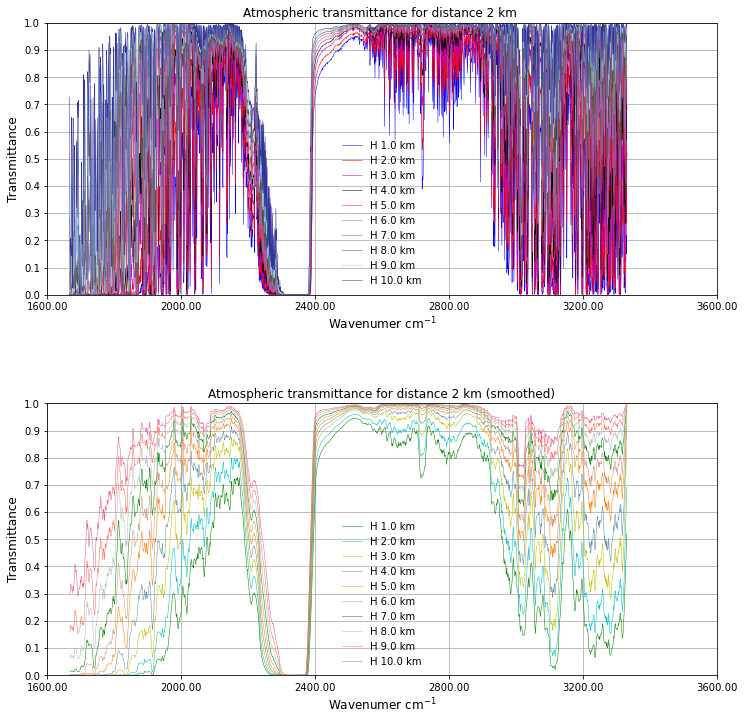

In [4]:
# to plot transmittance vs wavenunber for 2 km path length at different altitudes.
p = ryplot.Plotter(1,2,1,figsize=(12,12))

for targAlt in targAlts:
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    
    p.plot(1,df['wn'],df['TauA'],f'Atmospheric transmittance for distance {dist} km ','Wavenumber cm$^{-1}$',
           'Transmittance',label=[f'H {targAlt} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[1600,3340,0,1],linewidths=[0.5])
    p.plot(2,df['wn'],taufilt,f'Atmospheric transmittance for distance {dist} km (smoothed)','Wavenumber cm$^{-1}$',
           'Transmittance',label=[f'H {targAlt} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[1600,3340,0,1],linewidths=[0.5])


Plot the transmittance for a  fixed  altitude and different path lengths.

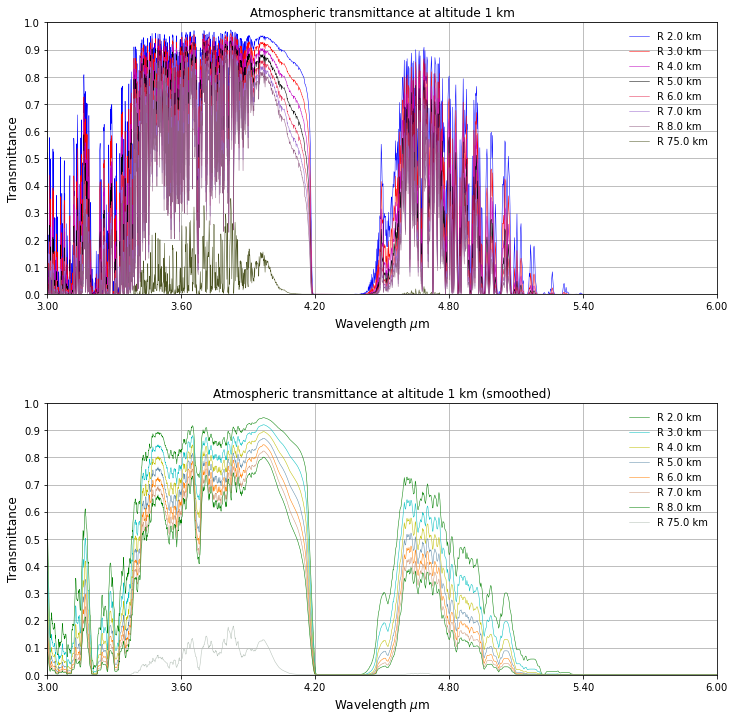

In [5]:
# to plot transmittance at 1 km altitude for different distances.
p = ryplot.Plotter(1,2,1,figsize=(12,12))

for targDist in targDists+backDists:
    alt = 1
    df = dfAtmo[(dfAtmo['H']==alt) & (dfAtmo['R']==targDist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    
    p.plot(1,df['wl'],df['TauA'],f'Atmospheric transmittance at altitude {alt} km','Wavelength $\mu$m',
           'Transmittance',label=[f'R {targDist} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1],linewidths=[0.5])
    p.plot(2,df['wl'],taufilt,f'Atmospheric transmittance at altitude {alt} km (smoothed)','Wavelength $\mu$m',
           'Transmittance',label=[f'R {targDist} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1],linewidths=[0.5])


Plot the path radiance  for a  fixed  path length and different altitudes.
Only the smoothed data is shown here.  The path radiance is shown as read in from the `tape7` files in units of 
\si{\watt\per(\centi\metre\squared.\steradian.\centi\metre^{-1})} and also processed to units of 
\si{\watt\per(\metre\squared.\steradian.\micro\metre)}.

It is evident that the path radiance is highest closer to the ground because the path traverses longer through the warmer atmosphere.  It is also clear that the spectral path radiance increases towards longer wavelengths, contributing much more flux than does the path radiance at shorter wavelengths.

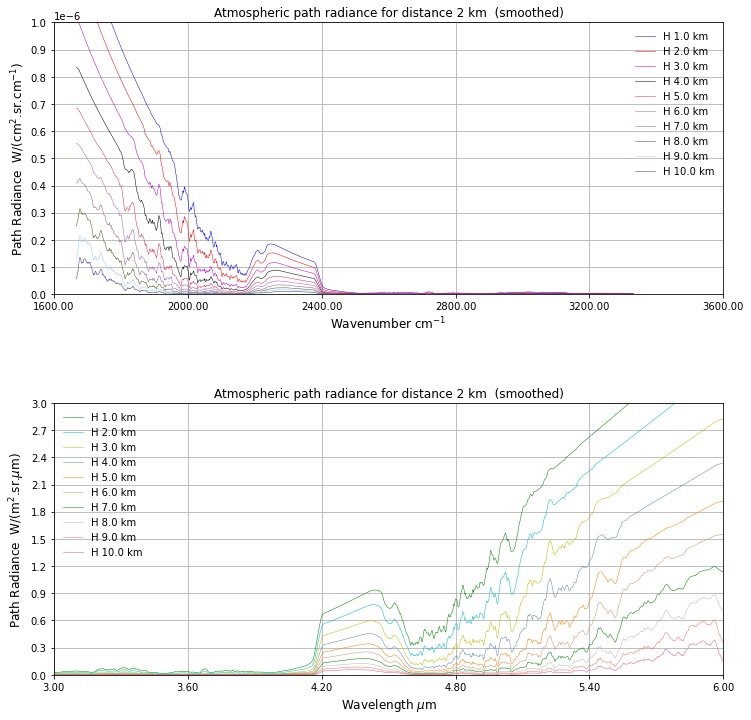

In [6]:
# to plot path radiance at 2 km path length and different altitudes
p = ryplot.Plotter(1,2,1,figsize=(12,12))
for targAlt in targAlts:
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    
    Lpfilt = ryutils.savitzkyGolay1D(df['Lpathcm-1'].values, window_size=21, order=0)
    p.plot(1,df['wn'],Lpfilt,f'Atmospheric path radiance for distance {dist} km  (smoothed)','Wavenumber cm$^{-1}$',
           'Path Radiance  W/(cm$^2$.sr.cm$^{-1}$)',label=[f'H {targAlt} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[1660,3340,0,1e-6],linewidths=[0.5])
    Lpfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
    p.plot(2,df['wl'],Lpfilt,f'Atmospheric path radiance for distance {dist} km  (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(m$^2$.sr.$\mu$m)',label=[f'H {targAlt} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,3],linewidths=[0.5])


Plot the path radiance  for a  fixed  altitude and different path lengths.
Only the smoothed data is shown here. The path radiance is shown as read in from the `tape7` files in units of 
\si{\watt\per(\centi\metre\squared.\steradian.\centi\metre^{-1})} and also processed to units of 
\si{\watt\per(\metre\squared.\steradian.\micro\metre)}.

The graphs below shows the path radiance for the horizontal path for longer distances.
Note that for the 75~\si{\kilo\metre} path the atmospheric path radiance approaches that of a thermal radiator at 16.7~\si{\celsius} with unity emissivity, i.e., as if it is an opaque wall.  This means that for long path distances (at low altitude) the atmosphere is essentially as opaque as a wall.

The interesting point here is that the horizontal path at 1~\si{\kilo\metre} altitude and 75~\si{\kilo\metre}  (long) path length radiates very closely to a black body at the temperature of the atmosphere at that altitude (refer to the atmospheric profile table above).

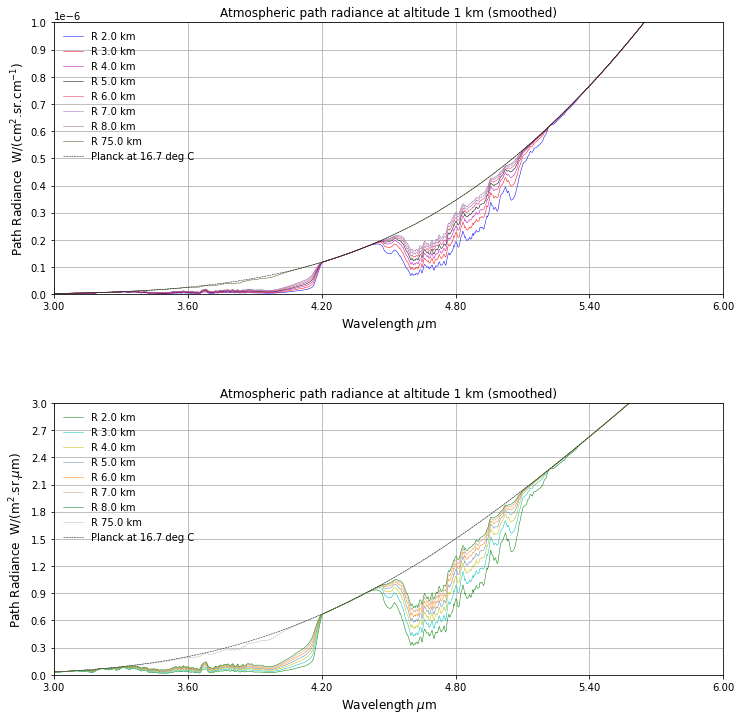

In [7]:
# to plot path radiance  at 1 km altitude
# filter to get one the 1 km alt data

Tc = 16.7
p = ryplot.Plotter(1,2,1,figsize=(12,12))

for targDist in targDists+backDists:
    alt = 1
    df = dfAtmo[(dfAtmo['H']==alt) & (dfAtmo['R']==targDist)]
    Lpfilt = ryutils.savitzkyGolay1D(df['Lpathcm-1'].values, window_size=21, order=0)
    p.plot(1,df['wl'],Lpfilt,f'Atmospheric path radiance at altitude {alt} km (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(cm$^2$.sr.cm$^{-1}$)',label=[f'R {targDist} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1e-6],linewidths=[0.5])
    Lpfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
    p.plot(2,df['wl'],Lpfilt,f'Atmospheric path radiance at altitude {alt} km (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(m$^2$.sr.$\mu$m)',label=[f'R {targDist} km'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,3],linewidths=[0.5])
Lplancken = ryplanck.planck(df['wn'],273.+Tc,'en') / np.pi
p.plot(1,df['wl'].values,Lplancken/1e4,f'Atmospheric path radiance at altitude {alt} km (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(cm$^2$.sr.cm$^{-1}$)',label=[f'Planck at {Tc} deg C'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1e-6],linewidths=[0.5], plotCol=['k'],linestyle=['--']);
Lplanckel = ryplanck.planck(df['wl'],273.+Tc,'el') / np.pi
p.plot(2,df['wl'].values,Lplanckel,f'Atmospheric path radiance at altitude {alt} km (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(m$^2$.sr.$\mu$m)',label=[f'Planck at {Tc} deg C'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,3],linewidths=[0.5], plotCol=['k'],linestyle=['--']);


The final path radiance graphs show the long range (75~\si{\kilo\metre}) background path radiance.
The path radiance curves show thermal radiator curves with atmospheric temperature superimposed.
Notice that at higher altitudes the thermal radiator curve defines the highest possible radiance (which the atmospheric path radiance cannot exceed).

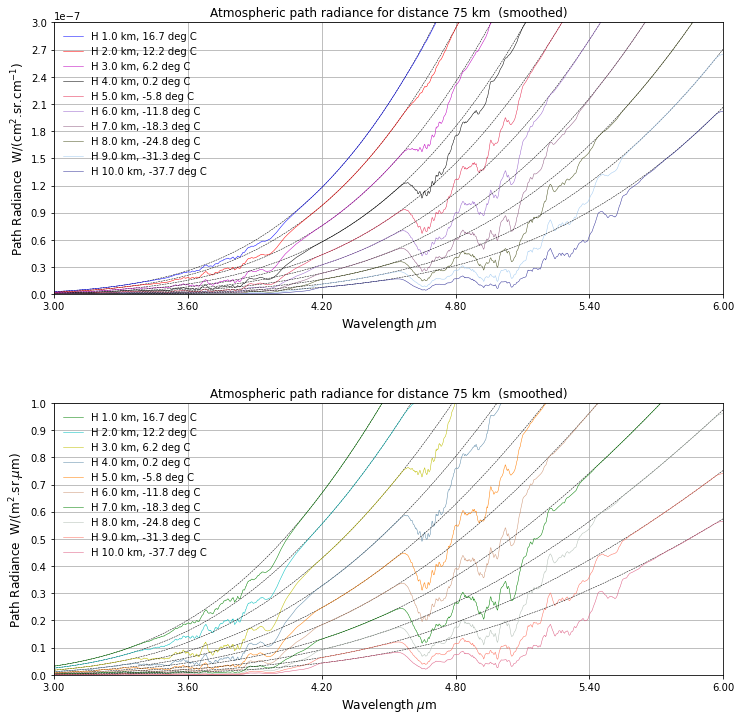

In [8]:
# to plot path radiance at 2 km path length and different altitudes
Tatmos = [21.2,16.7,12.2,6.2,0.2,-5.8,-11.8,-18.3,-24.8,-31.3,-37.7]

p = ryplot.Plotter(1,2,1,figsize=(12,12))
for targAlt in targAlts:
    dist = 75
    Tatmo = Tatmos[int(targAlt)]
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    Lplancken = ryplanck.planck(df['wn'],273.+Tatmo,'en') / np.pi
    p.plot(1,df['wl'],Lplancken/1e4,linewidths=[0.5],linestyle=['--'], plotCol=['k'])
    Lpfilt = ryutils.savitzkyGolay1D(df['Lpathcm-1'].values, window_size=21, order=0)
    p.plot(1,df['wl'],Lpfilt,f'Atmospheric path radiance for distance {dist} km  (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(cm$^2$.sr.cm$^{-1}$)',label=[f'H {targAlt} km, {Tatmo} deg C'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,0.3e-6],linewidths=[0.5])
    
    Lplanckel = ryplanck.planck(df['wl'],273.+Tatmo,'el') / np.pi
    p.plot(2,df['wl'],Lplanckel,linewidths=[0.5],linestyle=['--'], plotCol=['k'])
    Lpfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
    p.plot(2,df['wl'],Lpfilt,f'Atmospheric path radiance for distance {dist} km  (smoothed)','Wavelength $\mu$m',
           'Path Radiance  W/(m$^2$.sr.$\mu$m)',label=[f'H {targAlt} km, {Tatmo} deg C'],maxNX=5,xAxisFmt='%.2f',
          pltaxis=[3,6,0,1],linewidths=[0.5])



# Assignment  2



## Problem Statement 2
Complete the following:
\begin{enumerate}

\item Draw a picture and write a mathematical formulation for the spectral contrast flux on the sensor, showing the Planck law radiation, and how transmittance and path radiance must be accounted for.  Contrast is defined as the difference between the target and background radiance.

\item Plot the sensor spectral response.

\item Calculate and plot the target spectral radiance using Planck's law, with and without the sensor spectral response.

\item Calculate and plot the target spectral radiance in wavelength domain, as attenuated by the atmosphere and incident on the sensor, and 
as spectrally filtered by the sensor at different path lengths at an altitude of 1~\si{\kilo\metre}.


\item Calculate and plot the target spectral radiance in wavelength domain, as attenuated by the atmosphere and incident on the sensor, and 
as spectrally filtered by the sensor at different altitudes and a path length of 2~\si{\kilo\metre}.

\item Calculate and plot the path radiance only between the sensor and target as filtered by the sensor in the wavelength domain, for a constant altitude of 1~\si{\kilo\metre} for all distances.

\item Calculate and plot the target radiance plus path radiance between the sensor and target as filtered by the sensor in the wavelength domain, for a constant altitude of 1~\si{\kilo\metre} for all distances.

\item Calculate and plot the atmospheric path radiance  to space as filtered by the sensor in the wavelength domain, for a constant altitude of 1~\si{\kilo\metre} for all distances.

\item Calculate and plot the target spectral contrast radiance against the background observed by the sensor, including sensor response, and target emissivity. Do the calculation for an altitude of 1~\si{\kilo\metre}  and  all the path lengths. 

\item 
All of the above were calculated as  spectral values, varying with wavelength or wavenumber.  Now perform the spectral integral to calculate the total flux over all wavelengths.  Perform the spectral integral in the wavelength domain, with the sensor spectral response and atmospheric transmittance.

\end{enumerate}

Review the effect of the atmospheric transmittance and path radiance on the measured contrast.


## Solution 2

### Mathematical Formulation

![](pic/12Kpictures02.png)

The diagram above  shows the target, sensor and background.
The sensor has a shield that limits the  field of view solid angle.

All the terms in the following equations are spectral values.
\begin{equation}
\Delta L=
{S}
(\tau_\textrm{atmT}L_\textrm{targ}+L_\textrm{pathT})
-
{S}L_\textrm{pathB},
\end{equation}
where 
$S$ is the sensor spectral response,  
$\tau_\textrm{atmT}$ is the atmospheric transmittance between the sensor and target,  
$L_\textrm{targ} = \epsilon L_\textrm{bb}(T_\textrm{source})$ is the target radiance,  
$L_\textrm{pathT}$ is the atmospheric path radiance between the target and the sensor,  
$L_\textrm{pathB}$ is the atmospheric path radiance between the background (space) and the sensor.

Note that the path radiance is not multiplied by atmospheric transmittance because path radiance already includes the effect of transmittance, as the generating element.


The target area does not appear in the present radiance contrast formulation because the requested radiance is an area density value, hence area is implicitly defined in the radiance units. If the problem statement required the calculation of optical flux in \si{\watt}, the area would be required.

### Sensor Response 
Read in the sensor spectral response and interpolate to the Modtran spectral baseline.

In [9]:
# to load the sensor spectral response
dfSens = pd.read_csv('./data/12k/sensor/MWIR.dat', sep=' ',header=None)
dfSens.columns=['wl','wn','TauS']
# interpolate to Modtran spectrum
sTable = interp1d(dfSens['wn'], dfSens['TauS'], kind = 'linear')
tauS = sTable(wn)

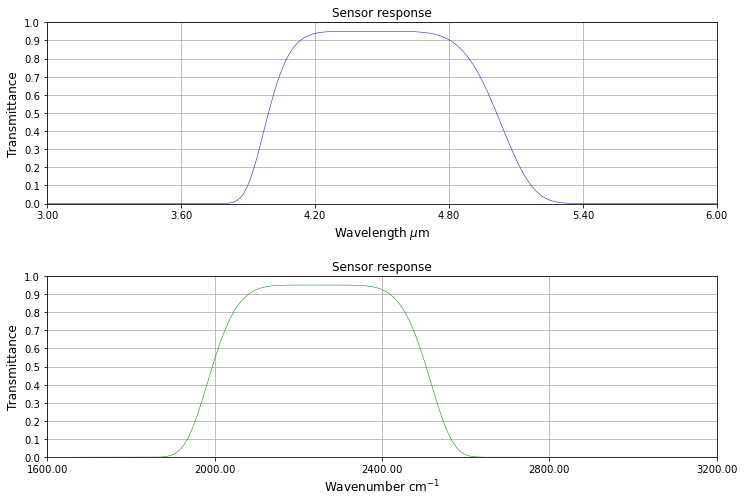

In [10]:
# to plot the sensor response
p = ryplot.Plotter(1,2,1,figsize=(12,8))
   
p.plot(1,wl,tauS,f'Sensor response','Wavelength $\mu$m',
       'Transmittance',maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,1],linewidths=[0.5])
p.plot(2,wn,tauS,f'Sensor response','Wavenumber cm$^{-1}$',
       'Transmittance',maxNX=5,xAxisFmt='%.2f',
      pltaxis=[1600,3200,0,1],linewidths=[0.5]);

The graphs above plot the sensor spectral response in both wavelength and wavenumber domains. The curves are similar but squashed and inverted along the spectral axis. The left-right inversion stems from the fact that the wavenumber is inversely related to wavelength.

Note that the spectral calculations can be done in either wavenumber or wavelength, the result should be exactly the same, as shown in the notebook\\
\lstinline{04-IntroductionToComputationalRadiometryWithPyradi.ipynb}.

### The Target Radiance

The following graphs show the target radiance at the source and in the sensor spectral band in wavelength and wavenumber units.

In [11]:
# to define the target properties
TempTC = 40 # i ndeg celsius
TempTK = 273.15+TempTC # in kelvin
Tarea = 2 # m2
Temis = 1 # emissivity

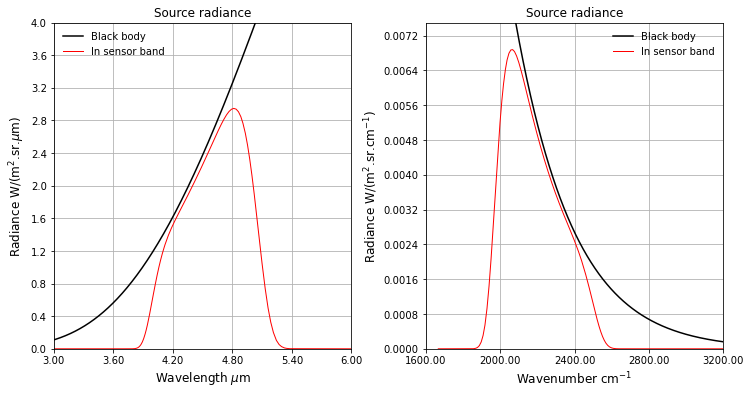

In [12]:
# to plot the target radiance only.
# watts in wavenumber domain
Ltargwn = ryplanck.planck(wn,TempTK,'en') / np.pi
# watts in wavelength domain
Ltargwl = ryplanck.planck(wl,TempTK,'el') / np.pi

p = ryplot.Plotter(1,1,2,figsize=(12,6))
p.plot(1,wl,Ltargwl,label=['Black body'],plotCol=['k'])
p.plot(1,wl,tauS*Ltargwl,f'Source radiance','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
       maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=['In sensor band'],plotCol=['r'])
p.plot(2,wn,Ltargwn,label=['Black body'],plotCol=['k'])
p.plot(2,wn,tauS*Ltargwn,f'Source radiance','Wavenumber cm$^{-1}$',
       'Radiance W/(m$^2$.sr.cm$^{-1}$)',maxNX=5,xAxisFmt='%.2f',label=['In sensor band'],
      pltaxis=[1600,3200,0,0.0075],linewidths=[1],plotCol=['r']);

### The Target Radiance through the atmosphere

In these graphs we plot the filtered transmittance because it is easier to read, the Modtran data has much more spectral variation.

Note how the water content in the atmosphere severely attenuates the target flux as wavelengths below 3.2 and above 5.3~\si{\micro\metre}. 
The deep attenuation dip at 4.3~\si{\micro\metre} is caused by atmospheric carbon dioxide CO\textsubscript{2}.
This carbon dioxide band is very strong and has an effect even at short distances in the lab.

Note how the sensor filter is designed to pass through the target flux that can propagate through the atmosphere, but cuts of flux in the atmospheric attenuation bands. The shorter pass wavelength is also set so as to reduce some of the sunlight effect, without affecting the target signal too much.

The sensor optical filter design process must optimise the signal to noise ratio and suppress large background signals.
Note that the filter itself also thermally radiates in the suppression bands (below 3.2 and above 5.3~\si{\micro\metre}) hence the infrared signal is not really reduced. In very demanding applications the filter is cooled down in order to reduce the filter emission in the suppression bands.

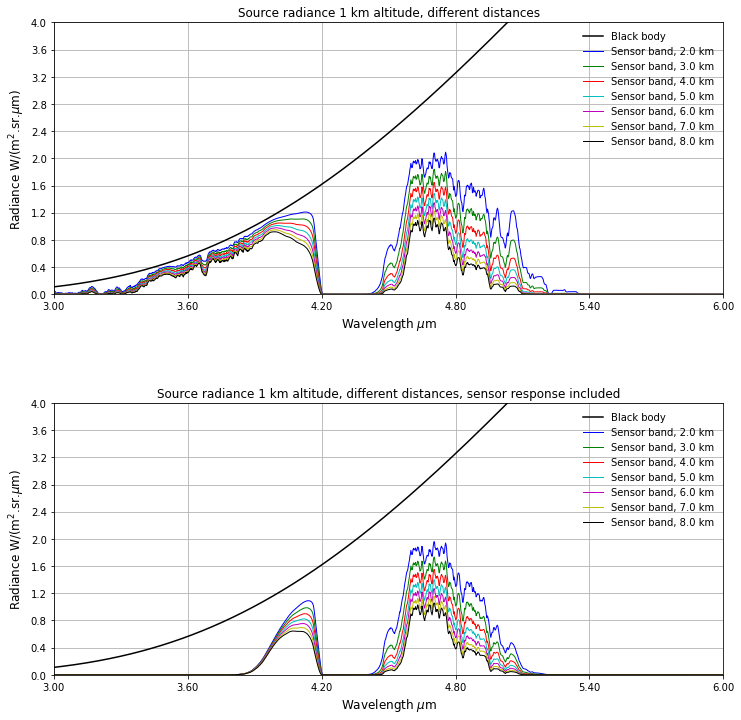

In [13]:
# to plot radiance at 1 km altitude for different distances.
p = ryplot.Plotter(1,2,1,figsize=(12,12))
p.plot(1,wl,Ltargwl,label=['Black body'],plotCol=['k'])
p.plot(2,wl,Ltargwl,label=['Black body'],plotCol=['k'])
for it,targDist in enumerate(targDists):
    alt = 1
    pltC = p.plotCol[it]
    df = dfAtmo[(dfAtmo['H']==alt) & (dfAtmo['R']==targDist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    
    p.plot(1,wl,taufilt*Ltargwl,f'Source radiance {alt} km altitude, different distances','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targDist} km'],plotCol=[pltC])
    p.plot(2,wl,taufilt*tauS*Ltargwl,f'Source radiance {alt} km altitude, different distances, sensor response included','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targDist} km'],plotCol=[pltC])


The following graphs show the effect of different altitudes for the same distance.
Note that at higher altitudes the target signal is much bigger than at low altitudes, especially above 5.5~\si{\micro\metre}.

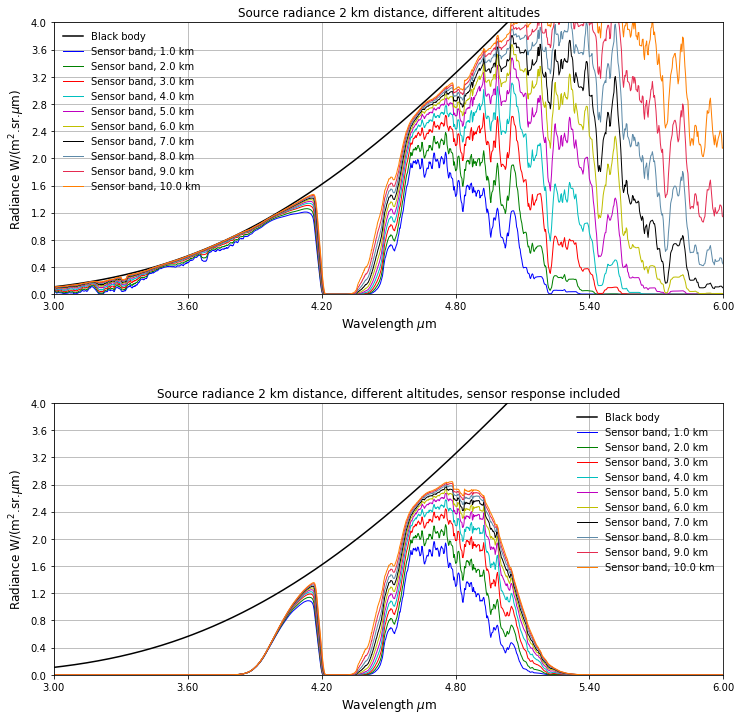

In [14]:
# to plot radiance at different altitudes and a distance of 2 km.
p = ryplot.Plotter(1,2,1,figsize=(12,12))
p.plot(1,wl,Ltargwl,label=['Black body'],plotCol=['k'])
p.plot(2,wl,Ltargwl,label=['Black body'],plotCol=['k'])
for it,targAlt in enumerate(targAlts):
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    
    pltC = p.plotCol[it]
    p.plot(1,wl,taufilt*Ltargwl,f'Source radiance {dist} km distance, different altitudes','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targAlt} km'],plotCol=[pltC])
    p.plot(2,wl,taufilt*tauS*Ltargwl,f'Source radiance {dist} km distance, different altitudes, sensor response included','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targAlt} km'],plotCol=[pltC])


### Path Radiance and Target Radiance

The first graph shows the path radiance to space (the 75~\si{\kilo\metre} path).  The path radiance is dominated by the dense and warm atmosphere close to the sensor; the atmospheric contribution at the longer distances is smaller because the atmosphere is cooler and less dense.  The atmospheric temperature is somewhat less than the target temperature, hence the radiance is lower as well.  The path radiance approaches the thermal radiance of a source at the same temperature, implying a reasonably high emissivity (around 80--90%).

The second graph shows the path radiance to the target only, at an altitude of 1~\si{\kilo\metre} and different altitudes. Note that the path radiance is always lower than a black body thermal radiator at the same temperature as the atmosphere.


The third  graph shows the path radiance to the target plus the target radiance, at an altitude of 1~\si{\kilo\metre} and different altitudes. Note that the target provides additional radiance pushing up the combined radiance to levels higher than a black body thermal radiator at the same temperature as the atmosphere.


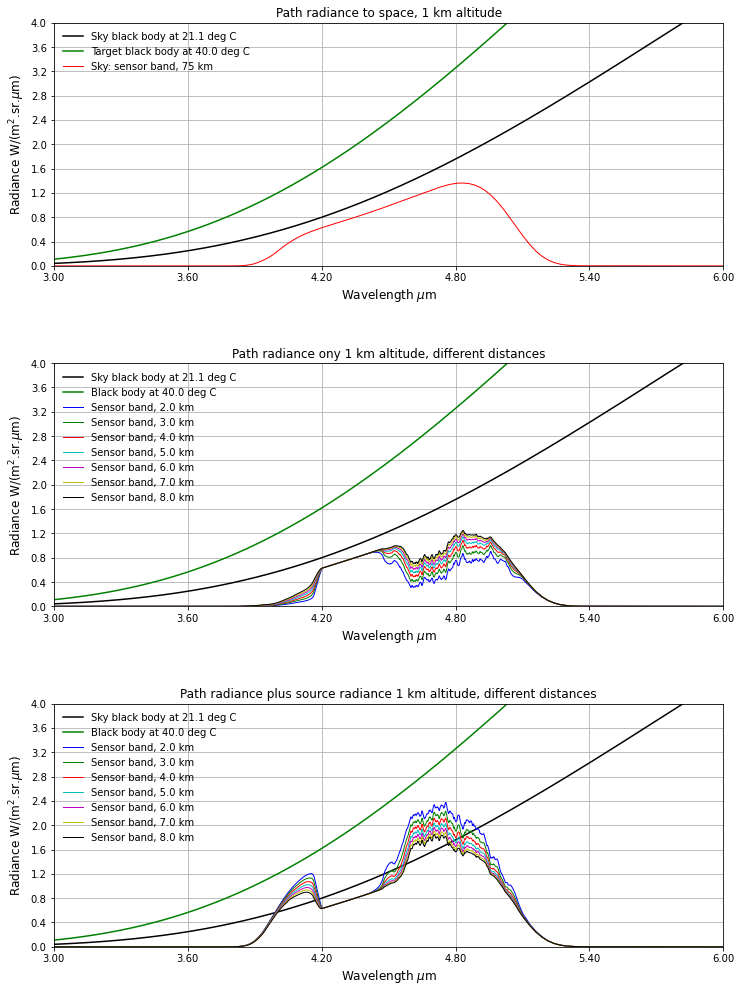

In [15]:
# to plot radiance at 1 km altitude for different distances.
p = ryplot.Plotter(1,3,1,figsize=(12,17))
Lpathumfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
tskyK = 294.2
tsky = tskyK - 273.15
Lskywl = ryplanck.planck(wl,tskyK,'el') / np.pi
p.plot(1,wl,Lskywl,label=[f'Sky black body at {tsky:.1f} deg C'],plotCol=['k'])
p.plot(1,wl,Ltargwl,label=[f'Target black body at {TempTC:.1f} deg C'],plotCol=['g'])
p.plot(2,wl,Lskywl,label=[f'Sky black body at {tsky:.1f} deg C'],plotCol=['k'])
p.plot(3,wl,Lskywl,label=[f'Sky black body at {tsky:.1f} deg C'],plotCol=['k'])
p.plot(2,wl,Ltargwl,label=[f'Black body at {TempTC:.1f} deg C'],plotCol=['g'])
p.plot(3,wl,Ltargwl,label=[f'Black body at {TempTC:.1f} deg C'],plotCol=['g'])
for it,targDist in enumerate(targDists):
    alt = 1
    pltC = p.plotCol[it]
    df = dfAtmo[(dfAtmo['H']==alt) & (dfAtmo['R']==targDist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    Lpathumfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
    
    p.plot(2,wl,tauS*Lpathumfilt,f'Path radiance ony {alt} km altitude, different distances','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targDist} km'],plotCol=[pltC])
    p.plot(3,wl,tauS*(taufilt*Ltargwl+Lpathumfilt),f'Path radiance plus source radiance {alt} km altitude, different distances',
           'Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targDist} km'],plotCol=[pltC])
    
targDist = 75
df = dfAtmo[(dfAtmo['H']==alt) & (dfAtmo['R']==targDist)]
Lpathskyum = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
taupathskyum = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
p.plot(1,wl,tauS*Lpathskyum,f'Path radiance to space, {alt} km altitude',
       'Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
       maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sky: sensor band, {targDist} km'],plotCol=['r']);


###  Radiance Contrast: Spectral and Integrated

The contrast is defined as (still all spectral variables):
\begin{equation}
\Delta L=
{S}
(\tau_\textrm{atmT}L_\textrm{targ}+L_\textrm{pathT})
-
{S}L_\textrm{pathB}
\end{equation}


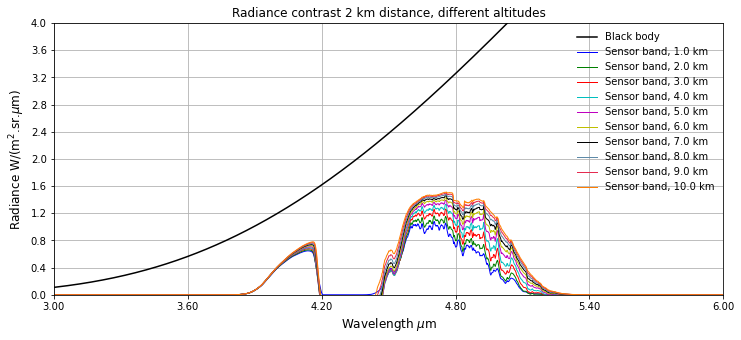

In [16]:
# to plot radiance at different altitudes and a distance of 2 km.
p = ryplot.Plotter(1,1,1,figsize=(12,5))
p.plot(1,wl,Ltargwl,label=['Black body'],plotCol=['k'])
for it,targAlt in enumerate(targAlts):
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=21, order=0)
    Lpathumfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=21, order=0)
    
    pltC = p.plotCol[it]
    Lconstrast = tauS * (taufilt*Ltargwl+Lpathumfilt - Lpathskyum )

    p.plot(1,wl,Lconstrast,f'Radiance contrast {dist} km distance, different altitudes','Wavelength $\mu$m','Radiance W/(m$^2$.sr.$\mu$m)',
           maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,4],linewidths=[1],label=[f'Sensor band, {targAlt} km'],plotCol=[pltC])


In the following code we calculate the integral under the radiance curve in the wavelength domain, using the `np.trapz()` function.  The results are captured in a Pandas data frame for analysis and plotting. The target contrast radiance is also plotted as a function of altitude.  Observe that the contrast increases with altitude because the atmosphere is cooler but the target temperature remains the same.

All radiance values in W/(m2.sr) integrated over the spectral band:
   Altitude  LintTarg  LintTargTot  LintTPath  LintCont
0       1.0  0.932954     1.586254   0.653300  0.521509
0       2.0  1.107930     1.591145   0.483215  0.526400
0       3.0  1.290206     1.615174   0.324969  0.550429
0       4.0  1.420116     1.641758   0.221642  0.577013
0       5.0  1.531318     1.680721   0.149403  0.615976
0       6.0  1.608343     1.710627   0.102283  0.645882
0       7.0  1.674109     1.741804   0.067696  0.677059
0       8.0  1.730142     1.774379   0.044237  0.709634
0       9.0  1.778052     1.806587   0.028535  0.741842
0      10.0  1.821831     1.839977   0.018146  0.775233


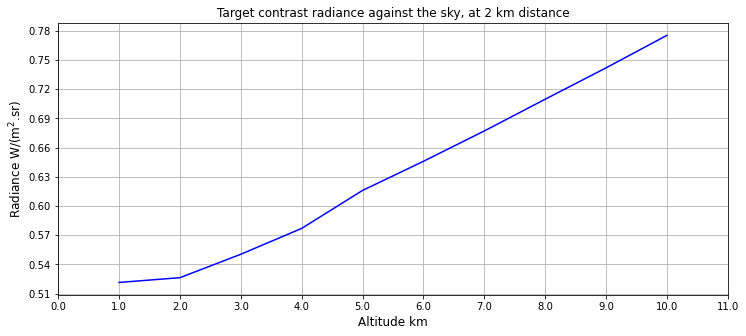

In [17]:
# to plot the spectrally integated radiance contrast.

dfInts = pd.DataFrame()
for it,targAlt in enumerate(targAlts):
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=3, order=0)
    Lpathumfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=3, order=0)
    Lconstrast = tauS * (taufilt*Ltargwl+Lpathumfilt - Lpathskyum )
    LintTarg = np.trapz(tauS * (taufilt*Ltargwl),x=-wl)
    LintTargTot = np.trapz(tauS * (taufilt*Ltargwl+Lpathumfilt),x=-wl)
    LintTPath = np.trapz(tauS*Lpathumfilt,x=-wl)
    LintCont= np.trapz(Lconstrast,x=-wl)
    dfInts = dfInts.append(pd.DataFrame().from_dict({
                'Altitude': [targAlt],
                'LintTarg':[LintTarg],
                'LintTargTot':[LintTargTot],
                'LintTPath':[LintTPath],
                'LintCont':[LintCont]}))
    
print('All radiance values in W/(m2.sr) integrated over the spectral band:')
print(dfInts)
p = ryplot.Plotter(1,1,1,figsize=(12,5))
p.plot(1,dfInts['Altitude'],dfInts['LintCont'],
      'Target contrast radiance against the sky, at 2 km distance','Altitude km','Radiance W/(m$^2$.sr)');


# Assignment  3

## The Scenario 3

The scenario is the same as for Assignment 2, but with the following variations:

1. The target emissivity is 0.8.  This means that the target reflectance is 1-0.8=0.2.   Assume the sun emissivity to be unity and the sun temperature to be 5700~K.

1. Assume unity atmospheric transmittance between the target and the sun.
1. The sun is present in the scene and illuminates the target.



## Problem Statement 3

With the sun illuminating the target now calculate the target contrast against the sky.

## Solution 3

![](pic/12Kpictures03.png)

Use the sun model towards the end of Chapter 3 in the book.

![](pic/sunmodel.png)



The contrast is then:
\begin{equation}
\Delta L=
 {S}\tau_\textrm{atmT}\epsilon L_\textrm{targ} 
+{S}\tau_\textrm{atmT} \num{2.17e-5} L_\textrm{sun}(5700)\tau_\textrm{75km}(1-\epsilon)
+{S} L_\textrm{pathT}
-{S}L_\textrm{pathB}
\end{equation}
where the sunlight reflectance is $\rho=1-\epsilon=0.2$ where $\epsilon=0.8$ is the target emissivity.

In [18]:
# to define the target properties
TempTC = 40 # i ndeg celsius
TempTK = 273.15+TempTC # in kelvin
Tarea = 2 # m2
Temis = 0.8 # emissivity

All radiance values in W/(m2.sr) integrated over the spectral band:
   Altitude  LinttargBB  LinttargSun  LinttargPath  Lintback  LintCont
0       1.0    0.746363     0.158522      0.653300  1.064745  0.493441
0       2.0    0.886344     0.176705      0.483215  1.064745  0.481519
0       3.0    1.032165     0.195268      0.324969  1.064745  0.487656
0       4.0    1.136093     0.208243      0.221642  1.064745  0.501233
0       5.0    1.225054     0.219531      0.149403  1.064745  0.529243
0       6.0    1.286675     0.228113      0.102283  1.064745  0.552326
0       7.0    1.339287     0.235893      0.067696  1.064745  0.578130
0       8.0    1.384114     0.242783      0.044237  1.064745  0.606389
0       9.0    1.422442     0.249151      0.028535  1.064745  0.635383
0      10.0    1.457465     0.255352      0.018146  1.064745  0.666219


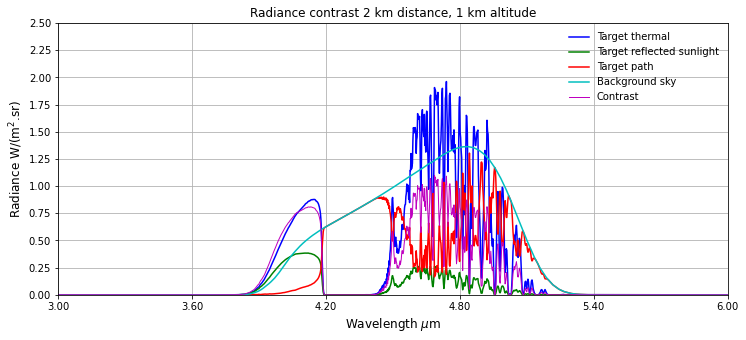

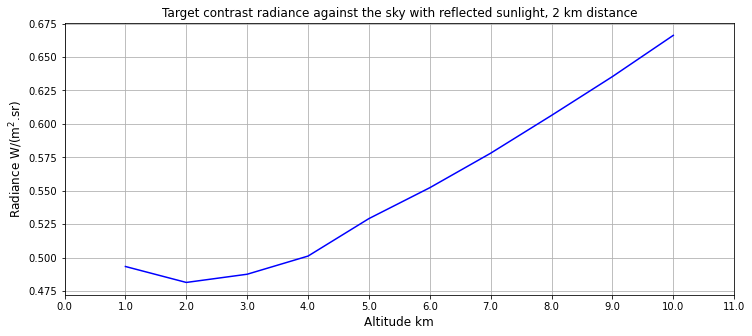

In [19]:
# to plot the spectrally integated radiance contrast.

dfInts = pd.DataFrame()
for it,targAlt in enumerate(targAlts):
    dist = 2
    df = dfAtmo[(dfAtmo['H']==targAlt) & (dfAtmo['R']==dist)]
    taufilt = ryutils.savitzkyGolay1D(df['TauA'].values, window_size=3, order=0)
    Lpathumfilt = ryutils.savitzkyGolay1D(df['Lpathum'].values, window_size=3, order=0)
    
    # Calculate the spectral values
    LtargBB = tauS * taufilt * Temis * Ltargwl
    LtargSun = tauS * taufilt * 2.17e-5 * (ryplanck.planck(wl,5700,'el')/np.pi) * (1-Temis) 
    LtargPath = tauS *  Lpathumfilt 
    Lback = tauS *  Lpathskyum 
    Lconstrast = LtargBB + LtargSun + LtargPath -Lback
    
    # spectral integrald
    LinttargBB= np.trapz(LtargBB,x=-wl)
    LinttargSun= np.trapz(LtargSun,x=-wl)
    LinttargPath= np.trapz(LtargPath,x=-wl)
    Lintback= np.trapz(Lback,x=-wl)
    LintCont= np.trapz(Lconstrast,x=-wl)
    
    # and store in the data frame
    dfInts = dfInts.append(pd.DataFrame().from_dict({
                'Altitude': [targAlt],
                'LinttargBB':[LinttargBB],
                'LinttargSun':[LinttargSun],
                'LinttargPath':[LinttargPath],
                'Lintback':[Lintback],
                'LintCont':[LintCont]}))
    if it==0:
        p = ryplot.Plotter(1,1,1,figsize=(12,5))
        p.plot(1,wl,LtargBB,label=['Target thermal'])
        p.plot(1,wl,LtargSun,label=['Target reflected sunlight'])
        p.plot(1,wl,LtargPath,label=['Target path'])
        p.plot(1,wl,Lback,label=['Background sky'])
        p.plot(1,wl,Lconstrast,f'Radiance contrast {dist} km distance, 1 km altitude',
               'Wavelength $\mu$m','Radiance W/(m$^2$.sr)',
               maxNX=5,xAxisFmt='%.2f',pltaxis=[3,6,0,2.5],linewidths=[1],
               label=['Contrast'])
print('All radiance values in W/(m2.sr) integrated over the spectral band:')
print(dfInts)
q = ryplot.Plotter(2,1,1,figsize=(12,5))
q.plot(1,dfInts['Altitude'],dfInts['LintCont'],
      'Target contrast radiance against the sky with reflected sunlight, 2 km distance','Altitude km','Radiance W/(m$^2$.sr)');


The reflected sunlight radiance is about 20--25% of the thermal radiance, hence it is not insignificant. If the target emissivity is lower (unlikely for most natural materials) the reflected sunlight will increase.  If the sunlight atmospheric attenuation is included it will reduce the reflected sunlight components.

Interestingly, the contrast reduces slightly at around 2--3~\si{kilo\metre} altitude and then increases for higher altitudes, but it remains lower than the case where the target emissivity is unity.

# Python and module versions, and dates

In [20]:
try:
    import pyradi.ryutils as ryutils
    print(ryutils.VersionInformation('matplotlib,numpy,pyradi,scipy,pandas'))
except:
    print("pyradi.ryutils not found")

Software versions
Python:   3.8.3 64bit [MSC v.1916 64 bit (AMD64)]
IPython:   7.26.0
OS:   Windows 10 10.0.19041 SP0
matplotlib:   3.4.3
numpy:   1.20.3
pyradi:   1.1.4
scipy:   1.7.1
pandas:   1.3.2
Fri Sep 10 12:07:47 2021 South Africa Standard Time
